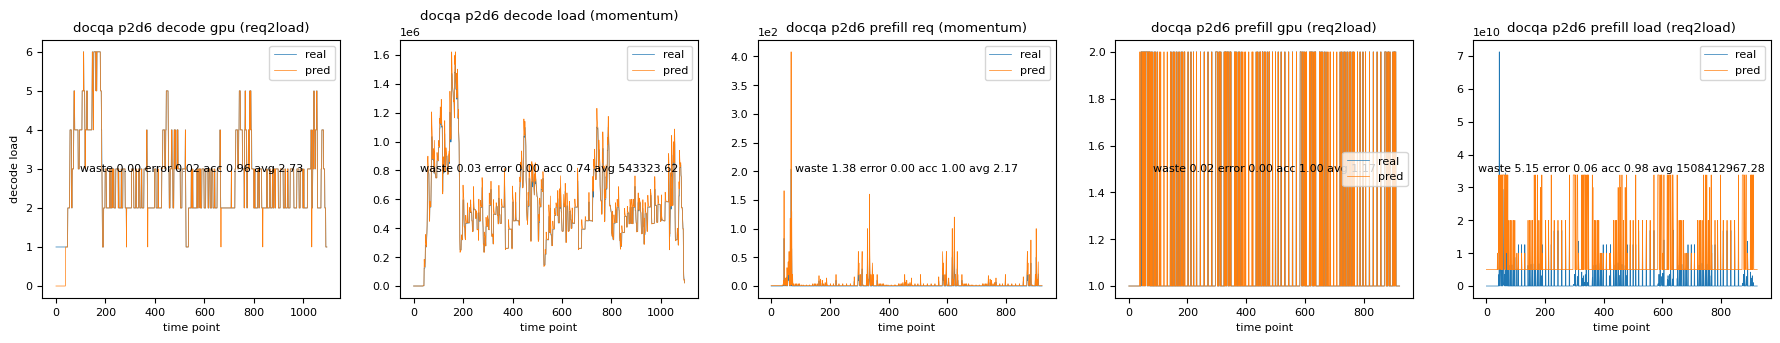

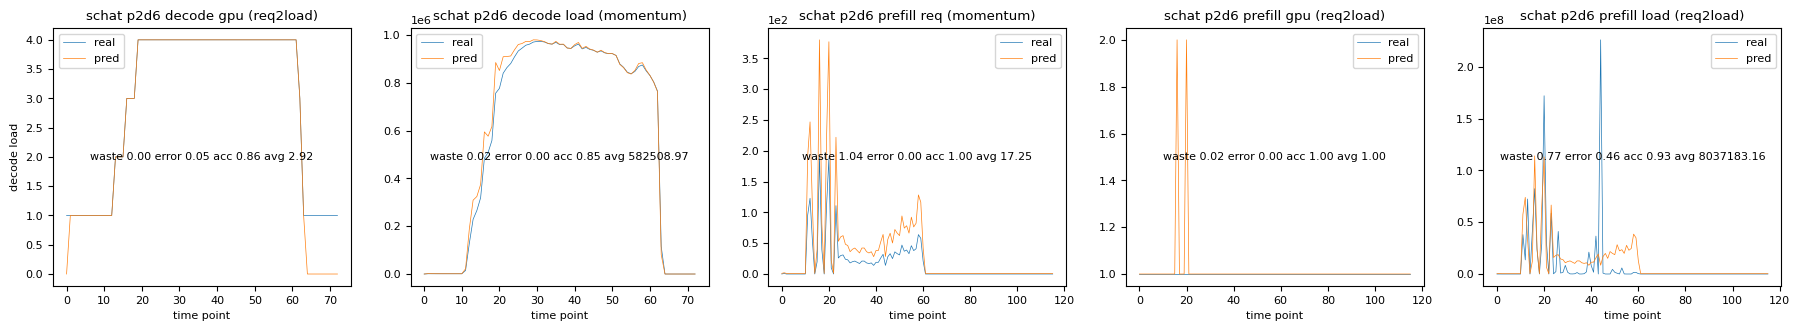

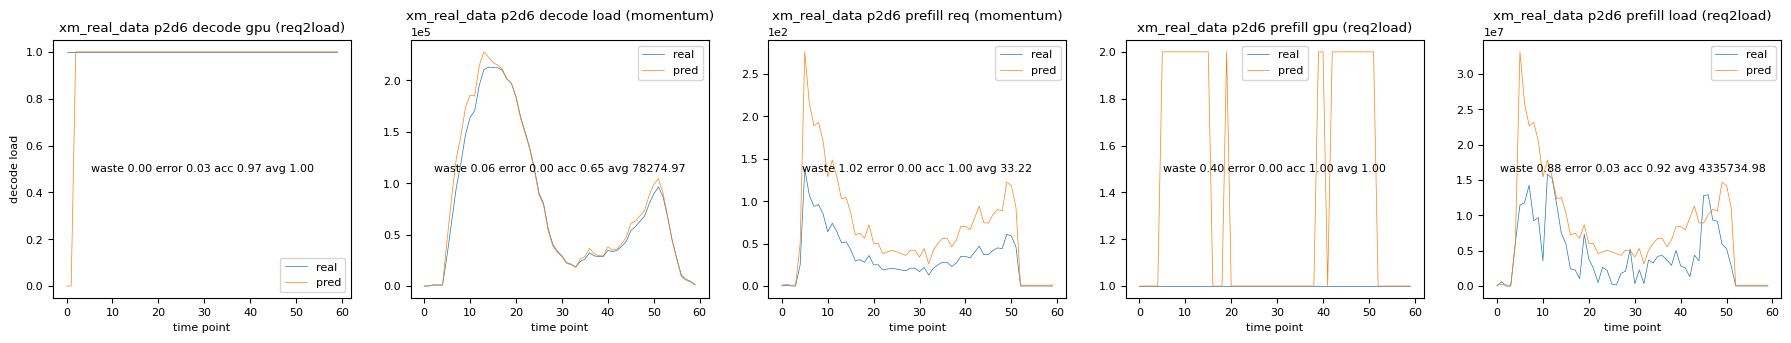

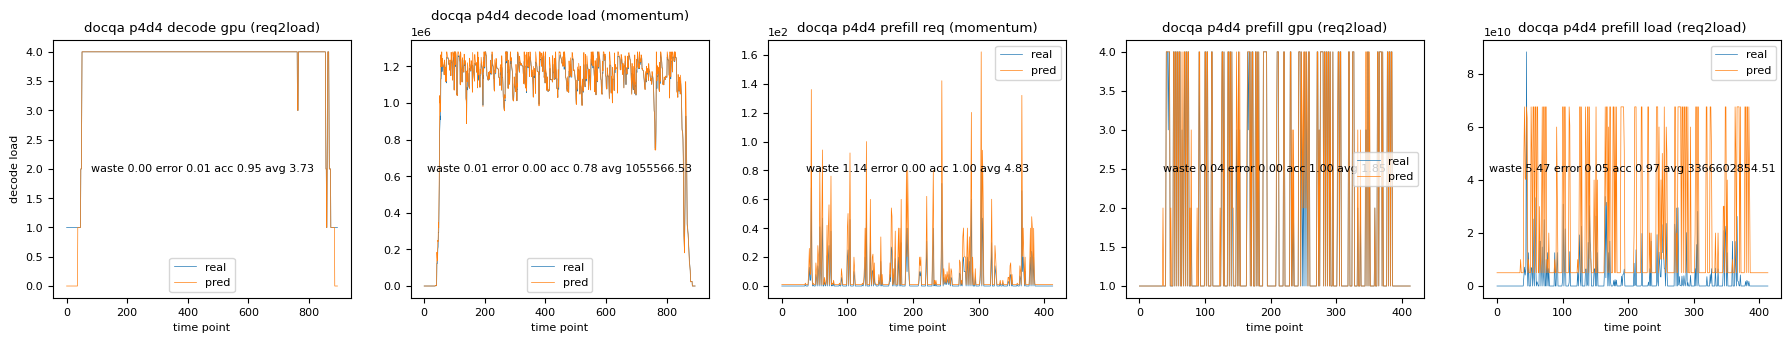

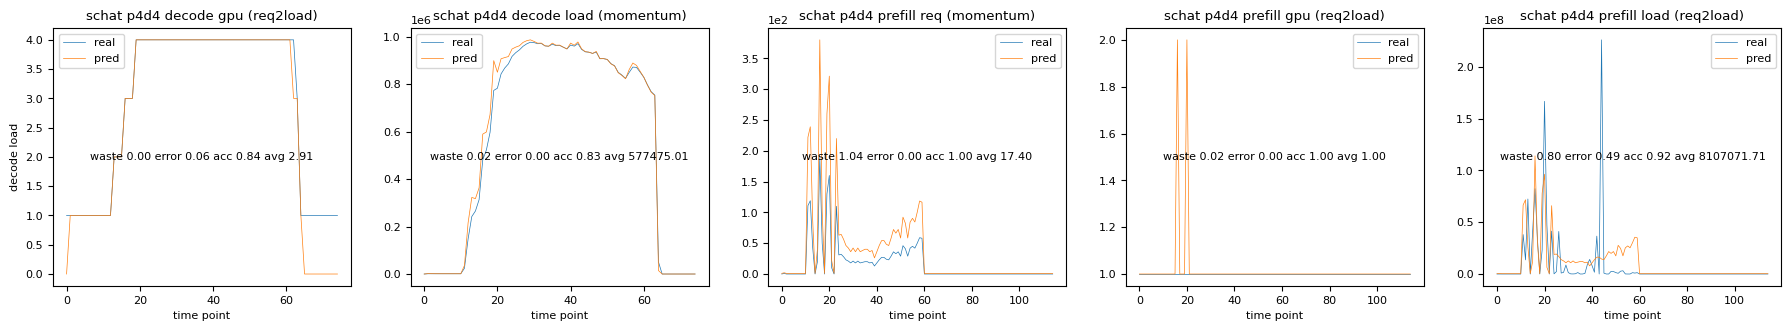

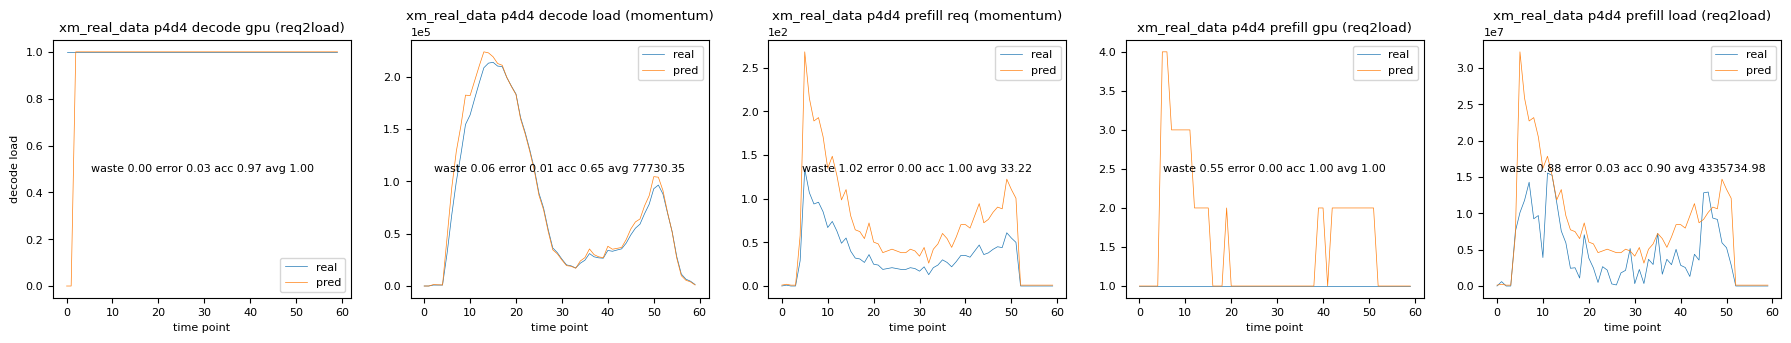

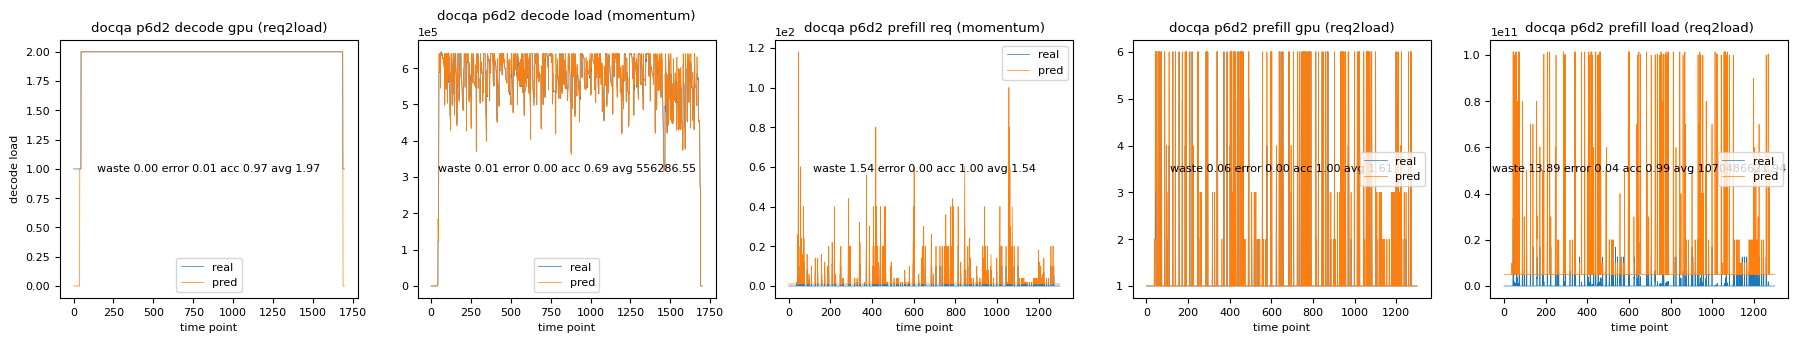

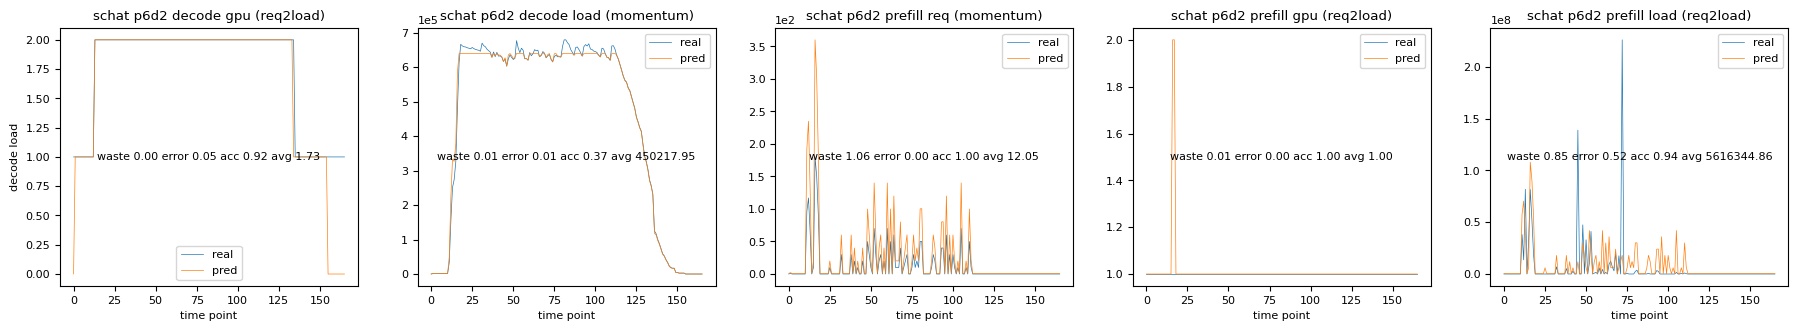

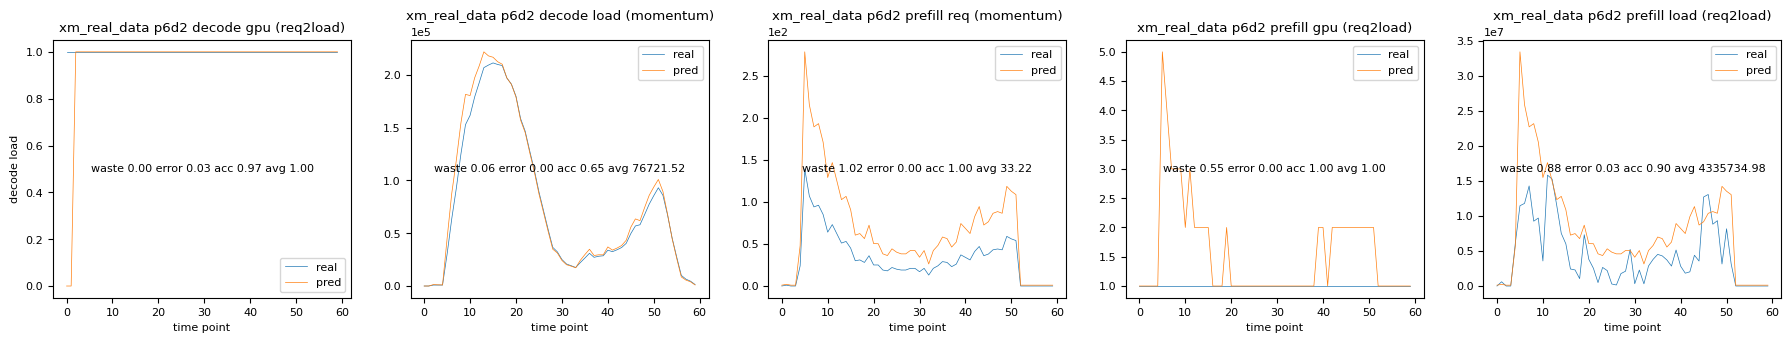

In [6]:
import json 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
# make sure that some matplotlib parameters are identical for all figures
font = {
    # 'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)
i = 1


col_size = 240.94499 # pt
text_size = 805.89 * 2 # pt
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = ((5)**0.5-1.0)/2.0         # Aesthetic ratio
fig_width = text_size*inches_per_pt  # width in inches
fig_height =fig_width * 0.15
fig_size = [fig_width,fig_height]

for cfg in ['p2d6', 'p4d4', 'p6d2']:
    p, d = cfg.split('d')
    pnum = int(p[1:])
    dnum = int(d)
    for data_name in ['docqa', 'schat', 'xm_real_data']:

        plt.figure(figsize=fig_size) 
        # plt.subplot(4,1)

        fig_idx = 0
        # create sub figs 

        def vis_pred(sorted_keys, real, pred, algo):
            # select 
            global fig_idx
            plt.subplot(1,5,fig_idx+1)
            fig_idx += 1
            real = np.array(real)
            pred = np.array(pred)
            plt.plot(sorted_keys, real, label='real', linewidth=0.5)
            plt.plot(sorted_keys, pred, label='pred', linewidth=0.5)
            acc = (real <= pred).mean()
            waste = np.where(real <= pred, pred - real, 0).sum() / real.sum()
            error = np.where(real > pred, real - pred, 0).sum() / real.sum()
            avg = real.mean()
            plt.xlabel('time point')
            if fig_idx == 1: plt.ylabel('decode load')
            plt.legend()
            plt.title(f'{algo}')
            extra = f'waste {waste:.2f} error {error:.2f} acc {acc:.2f} avg {avg:.2f}'
            plt.text(0.5, 0.5, extra, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            # show y as xx e6
            plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        decode = f'/data/fanyunqian/sch/distkv/lightllm/evaluation/task11/decode_history.{cfg}.0.1.{data_name}.json'
        data = json.load(open(decode))['decode']
        data = {int(k) : v for k,v in data.items()}
        sorted_keys = sorted(data.keys())
        real_load = [sum(data[k]['token_load_list']) for k in sorted_keys]
        est_load = [data[k]['details']['est_token'] for k in sorted_keys]
        real_req = [sum(data[k]['batch_load_list']) for k in sorted_keys]

        est_gpus = [min(math.ceil(est_load_ / (320000 * 0.8)), dnum) for est_load_ in est_load]
        real_gpus = [data[k]['decision'] for k in sorted_keys]
        # real_gpus = [math.ceil(real_load_ / (320000 * 0.8)) for real_load_ in real_load]
        vis_pred(sorted_keys, real_gpus, est_gpus, f'{data_name} {cfg} decode gpu (req2load)')
        vis_pred(sorted_keys, real_load, est_load, f'{data_name} {cfg} decode load (momentum)')


        prefill = f'/data/fanyunqian/sch/distkv/lightllm/evaluation/task11/prefill_history.{cfg}.0.1.{data_name}.json'
        data = json.load(open(prefill))['prefill']
        data = {int(k) : v for k,v in data.items()}
        sorted_keys = sorted(data.keys())
        real_load = [(data[k]['details']['total_req']) for k in sorted_keys]
        est_load = [data[k]['details']['est_req'] for k in sorted_keys]

        vis_pred(sorted_keys, real_load, est_load, f'{data_name} {cfg} prefill req (momentum)')

        p_thresh = {'docqa': 1e10, 'schat': 1e8, 'xm_real_data': 1e7}
        real_load = [sum(data[k]['token_load_list']) for k in sorted_keys]
        est_load = [data[k]['details']['est_token'] for k in sorted_keys]
        est_gpus = [min(math.ceil(est_load_ / (p_thresh[data_name] * 0.8)), pnum) for est_load_ in est_load]
        real_gpus = [data[k]['decision'] for k in sorted_keys]
        vis_pred(sorted_keys, real_gpus, est_gpus, f'{data_name} {cfg} prefill gpu (req2load)')
        vis_pred(sorted_keys, real_load, est_load, f'{data_name} {cfg} prefill load (req2load)')